In [22]:
import numpy as np
import pandas as pd
import s3fs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

from datetime import datetime
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from dateutil import relativedelta

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def get_holidays():
    """
    Get Black Friday dates
    """
    black_friday = pd.DataFrame({
                  'holiday': 'black_friday',
                  'ds': pd.to_datetime(['2017-11-24', '2018-11-23', '2019-11-29',
                                        '2020-11-27', '2021-11-26', '2022-11-25',
                                        '2023-11-24', '2024-11-29', '2025-11-28']),
                  'lower_window': -1,
                  'upper_window': 3,
                })

    xmas = pd.DataFrame({
                  'holiday': 'christmas',
                  'ds': pd.to_datetime(['2017-12-25', '2018-12-25', '2019-12-25',
                                        '2020-12-25', '2021-12-25', '2022-12-25',
                                        '2023-12-25', '2024-12-25', '2025-12-25']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    new_year = pd.DataFrame({
                  'holiday': 'new_year',
                  'ds': pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01',
                                        '2020-01-01', '2021-01-01', '2022-01-01',
                                        '2023-01-01', '2024-01-01', '2025-01-01']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    carnival = pd.DataFrame({
                  'holiday': 'carnival',
                  'ds': pd.to_datetime(['2017-02-28', '2018-02-13', '2019-03-05',
                                        '2020-02-25', '2021-02-16', '2022-03-01',
                                        '2023-02-21', '2024-02-13', '2025-03-04']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    good_friday = pd.DataFrame({
                  'holiday': 'good_friday',
                  'ds': pd.to_datetime(['2018-03-18','2019-04-19','2020-04-10',
                                        '2021-04-02','2022-04-15','2023-04-07',
                                        '2024-03-29']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    # long holidays

    monday = pd.DataFrame({
                  'holiday': 'monday',
                  'ds': pd.to_datetime(['2020-09-07','2020-10-12','2020-11-02',
                                        '2021-11-15']),
                  'lower_window': -2,
                  'upper_window': 0,
                })

    friday = pd.DataFrame({
                  'holiday': 'friday',
                  'ds': pd.to_datetime(['2018-09-07','2018-10-12','2018-11-02',
                                        '2019-11-15','2020-05-01']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    # Different cases
    # 2019-12-30 (christmas and New year's eve from tuesday to wednesday. Monday was also affected)
    others = pd.DataFrame({
                  'holiday': 'others',
                  'ds': pd.to_datetime(['2019-12-23','2019-12-30']),
                  'lower_window': 0,
                  'upper_window': 0,
                })

    holidays = pd.concat((black_friday, xmas, new_year, carnival,
                         monday, friday, others))

    return holidays

### Reading data

In [49]:
data = pd.read_csv('s3://bsa-correlation-one/electronics/Celular_data.csv', dtype={'gtin':'str'})

In [50]:
data['date'] = pd.to_datetime(data['date'])
data['count'] = 1
data.drop(columns='Unnamed: 0', inplace=True)

In [51]:
data = data.groupby([pd.Grouper(key='date',freq='D'), 'gtin']).sum().reset_index() #.agg('gmv':'sum', 'revenue':'sum','cogs':'sum', 'gross_profit': 'sum','orders':'sum', olist_price:'')

In [54]:
cols = ['competition_price', 'total_discount', 'orders', 'olist_price', 'freight_value',
        'commission_freight', 'commission_product', 'price_freight_shift',
        'price_discount', 'stock_max', 'stock_min', 'stock_avg', 'price_max',
        'price_min', 'price_avg', 'offer_max', 'offer_min', 'offer_avg']

In [55]:
for col in cols:
    data[col] = data[col].values / data['count'].values

In [56]:
holidays = get_holidays()

### Single SKU

In [57]:
data.groupby('gtin')[['orders','gmv','gross_profit']].sum().sort_values(by=['gross_profit'], ascending=False)

,orders,gmv,gross_profit
gtin,,,
7893299910340,1270.933333,1159827.85,52724.66
7893299910425,2522.000000,1041601.45,45663.98
7899838861371,615.833333,537226.96,33281.96
7892509104661,638.350000,433411.29,19324.43
7892509104586,529.916667,400341.66,15415.69
...,...,...,...
7898573296332,0.000000,0.00,0.00
7898573295281,0.000000,0.00,0.00
7898567772774,0.000000,0.00,0.00


In [58]:
#gtin = '7893299910340' # Celular LG K9
gtin = '7893299741364' # Celular LG A275

In [59]:
df = data[data['gtin']==gtin].reset_index(drop=True)

In [60]:
df.tail()

,date,gtin,competition_price,gmv,revenue,cogs,gross_profit,total_discount,orders,olist_price,freight_value,commission_freight,commission_product,price_freight_shift,price_discount,stock_max,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,count
37,2020-02-24,7893299741364,87.0,626.39,119.02,76.12,42.90,0.000000,4.0,72.500000,18.465833,0.158333,0.158333,0.0,0.000000,75.0,70.0,72.400000,87.0,87.0,87.0,87.0,87.0,87.0,2
38,2020-02-25,7893299741364,87.0,312.37,59.35,37.96,21.39,3.480000,1.5,83.520000,18.367500,0.190000,0.190000,0.0,3.480000,69.0,68.0,68.500000,87.0,87.0,87.0,87.0,87.0,87.0,2
39,2020-02-26,7893299741364,78.3,1945.69,369.70,238.20,131.50,0.454545,12.0,62.818182,17.452028,0.138182,0.138182,0.0,0.454545,67.0,57.0,62.047619,87.0,87.0,87.0,87.0,87.0,87.0,2
40,2020-02-27,7893299741364,78.3,2128.57,404.41,251.13,153.28,1.670400,41.5,41.046600,12.015425,0.090250,0.090250,0.0,0.278400,80.0,60.0,70.419355,87.0,87.0,87.0,87.0,87.0,87.0,2
41,2020-02-28,7893299741364,78.3,1772.53,336.80,213.45,123.35,0.217500,16.5,47.297885,14.497846,0.103769,0.103769,0.0,0.217500,59.0,54.0,56.111111,87.0,87.0,87.0,87.0,87.0,87.0,2


In [ ]:
#df.plot(x='date',y='orders')
#plt.tight_layout()

#### Prophet

In [61]:
df = df[['date', 'competition_price', 'olist_price', 'freight_value','stock_max', 'orders']].copy()

In [62]:
df.competition_price.replace(to_replace=0, value=np.nan, inplace=True)
df['competition_price'] = df.competition_price.fillna(method='bfill').fillna(method='ffill')

df.freight_value.replace(to_replace=0, value=np.nan, inplace=True)
df['freight_value'] = df.freight_value.fillna(value=df.freight_value.median())

In [63]:
df.rename(columns={'date':'ds', 'orders':'y'}, inplace=True)

In [64]:
df.tail()

,ds,competition_price,olist_price,freight_value,stock_max,y
37,2020-02-24,87.0,72.500000,18.465833,75.0,4.0
38,2020-02-25,87.0,83.520000,18.367500,69.0,1.5
39,2020-02-26,78.3,62.818182,17.452028,67.0,12.0
40,2020-02-27,78.3,41.046600,12.015425,80.0,41.5
41,2020-02-28,78.3,47.297885,14.497846,59.0,16.5


In [65]:
model = Prophet(holidays=holidays, interval_width=0.95)

In [66]:
model.add_regressor('competition_price')
model.add_regressor('olist_price')
model.add_regressor('freight_value')
model.add_regressor('stock_max')

In [67]:
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [77]:
n_periods = 7

In [88]:
start_date = df.iloc[-1]['ds'] + relativedelta.relativedelta(day=1)
future_range = pd.date_range(start_date, periods=n_periods, freq='D')
future_df = pd.DataFrame({'future_date': future_range})

In [89]:
future = model.make_future_dataframe(periods=n_periods)

In [90]:
# future values for regressors (3 predictions)

future_df['competition_price'] = [78] * n_periods
future_df['olist_price']       = [50] * n_periods
future_df['freight_value']     = [0] * n_periods
future_df['stock_max']         = [60] * n_periods

In [91]:
regressors = ['competition_price', 'olist_price', 'freight_value', 'stock_max']

for regressor in regressors:
    future[regressor] = df[regressor].tolist() + future_df[regressor].tolist()

In [92]:
future.tail(10)

,ds,competition_price,olist_price,freight_value,stock_max
39,2020-02-26,78.3,62.818182,17.452028,67.0
40,2020-02-27,78.3,41.046600,12.015425,80.0
41,2020-02-28,78.3,47.297885,14.497846,59.0
42,2020-02-29,78.0,50.000000,0.000000,60.0
43,2020-03-01,78.0,50.000000,0.000000,60.0
44,2020-03-02,78.0,50.000000,0.000000,60.0
45,2020-03-03,78.0,50.000000,0.000000,60.0
46,2020-03-04,78.0,50.000000,0.000000,60.0
47,2020-03-05,78.0,50.000000,0.000000,60.0
48,2020-03-06,78.0,50.000000,0.000000,60.0


In [93]:
forecast = model.predict(future)

In [94]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,black_friday,black_friday_lower,black_friday_upper,carnival,carnival_lower,carnival_upper,christmas,christmas_lower,christmas_upper,competition_price,competition_price_lower,competition_price_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,freight_value,freight_value_lower,freight_value_upper,friday,friday_lower,friday_upper,holidays,holidays_lower,holidays_upper,monday,monday_lower,monday_upper,new_year,new_year_lower,new_year_upper,olist_price,olist_price_lower,olist_price_upper,others,others_lower,others_upper,stock_max,stock_max_lower,stock_max_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
44,2020-03-02,10.097632,10.592415,30.313733,10.097632,10.097632,9.864321,9.864321,9.864321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.390632,0.390632,0.390632,14.059121,14.059121,14.059121,1.106729,1.106729,1.106729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.69348,12.69348,12.69348,0.0,0.0,0.0,-0.131721,-0.131721,-0.131721,-4.194800,-4.194800,-4.194800,0.0,0.0,0.0,19.961952
45,2020-03-03,10.188604,14.712847,33.190841,10.188604,10.188604,14.043575,14.043575,14.043575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.390632,0.390632,0.390632,14.059121,14.059121,14.059121,1.106729,1.106729,1.106729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.69348,12.69348,12.69348,0.0,0.0,0.0,-0.131721,-0.131721,-0.131721,-0.015545,-0.015545,-0.015545,0.0,0.0,0.0,24.232179
46,2020-03-04,10.279576,13.636599,33.058365,10.279576,10.279577,13.015231,13.015231,13.015231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.390632,0.390632,0.390632,14.059121,14.059121,14.059121,1.106729,1.106729,1.106729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.69348,12.69348,12.69348,0.0,0.0,0.0,-0.131721,-0.131721,-0.131721,-1.043889,-1.043889,-1.043889,0.0,0.0,0.0,23.294808
47,2020-03-05,10.370549,17.256149,37.096619,10.370549,10.370549,16.600900,16.600900,16.600900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.390632,0.390632,0.390632,14.059121,14.059121,14.059121,1.106729,1.106729,1.106729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.69348,12.69348,12.69348,0.0,0.0,0.0,-0.131721,-0.131721,-0.131721,2.541779,2.541779,2.541779,0.0,0.0,0.0,26.971449
48,2020-03-06,10.461521,16.698943,36.359950,10.461521,10.461521,16.296315,16.296315,16.296315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.390632,0.390632,0.390632,14.059121,14.059121,14.059121,1.106729,1.106729,1.106729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.69348,12.69348,12.69348,0.0,0.0,0.0,-0.131721,-0.131721,-0.131721,2.237194,2.237194,2.237194,0.0,0.0,0.0,26.757836


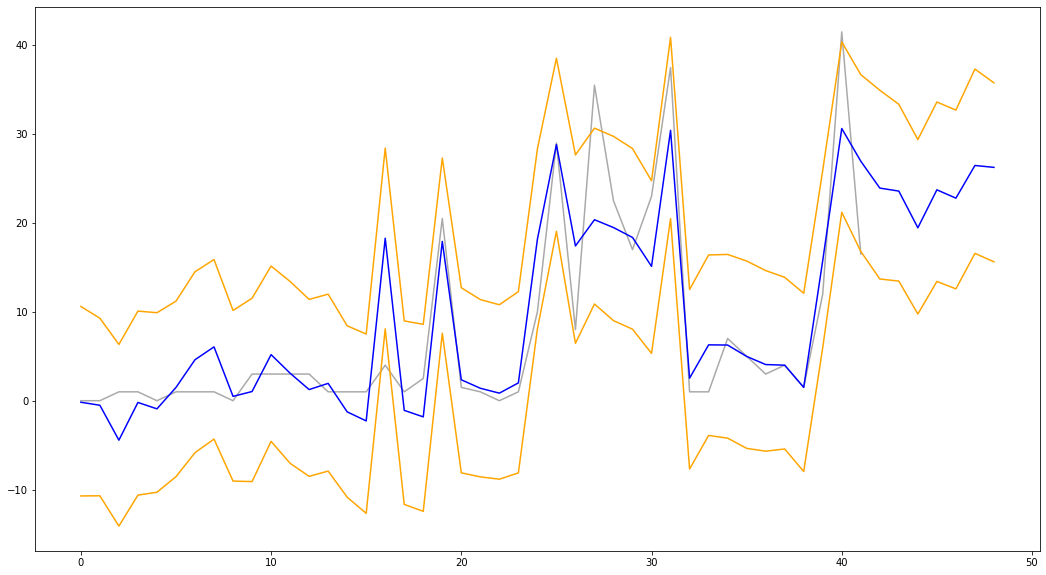

In [76]:
# original
plt.figure(figsize=(18,10))
plt.plot(df['y'], color='darkgrey')
plt.plot(forecast['yhat'], color='blue')
plt.plot(forecast['yhat_upper'], color='orange')
plt.plot(forecast['yhat_lower'], color='orange')

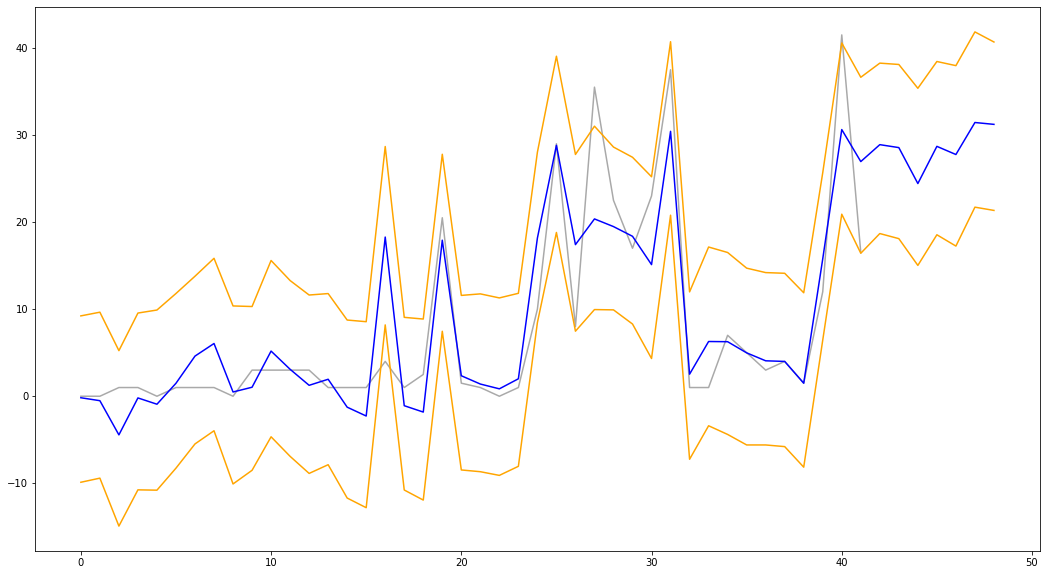

In [85]:
# Lower price (20%)
plt.figure(figsize=(18,10))
plt.plot(df['y'], color='darkgrey')
plt.plot(forecast['yhat'], color='blue')
plt.plot(forecast['yhat_upper'], color='orange')
plt.plot(forecast['yhat_lower'], color='orange')

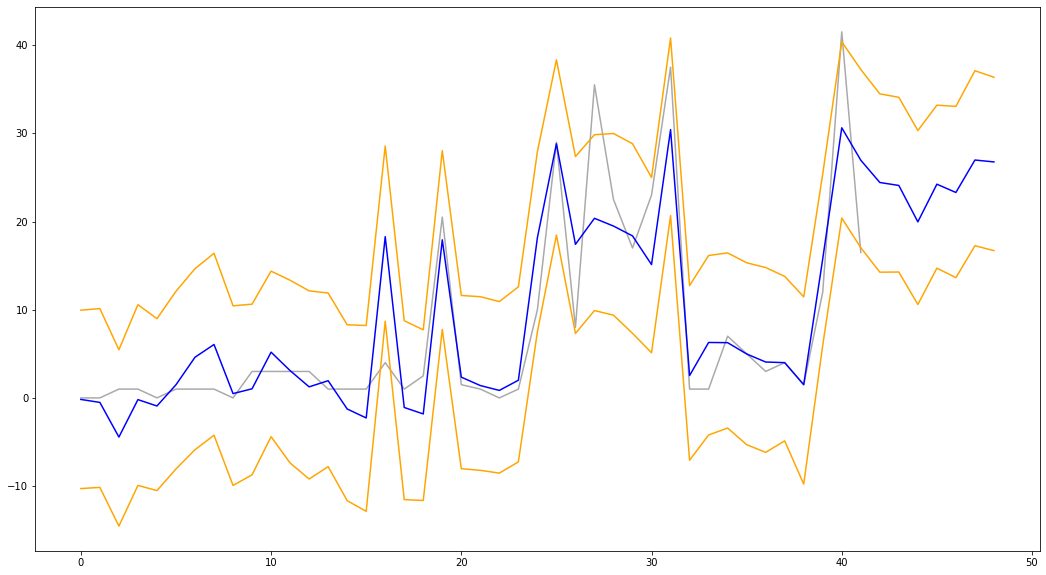

In [95]:
# Free Shipping
plt.figure(figsize=(18,10))
plt.plot(df['y'], color='darkgrey')
plt.plot(forecast['yhat'], color='blue')
plt.plot(forecast['yhat_upper'], color='orange')
plt.plot(forecast['yhat_lower'], color='orange')

In [ ]:
cross_validation(model, horizon='7 days')

### Grouped Cellphones

In [15]:
df = data.groupby(pd.Grouper(key='date',freq='D'))[['orders']].sum().reset_index()

In [16]:
df.columns = ['ds', 'y']

In [17]:
model = Prophet(interval_width=0.95, holidays=holidays, yearly_seasonality=True)
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
future = model.make_future_dataframe(periods=30, freq='D', include_history=True)

fcst = model.predict(future)

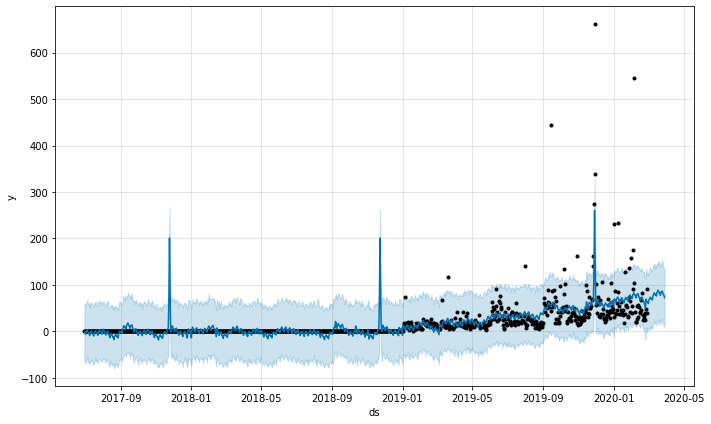

In [31]:
model.plot(fcst)
plt.show()

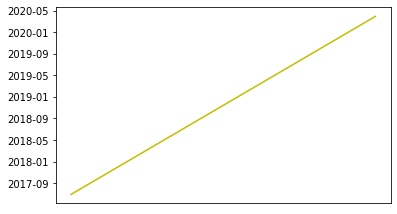

In [26]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.plot('ds','y', data=fcst)
plt.gcf().autofmt_xdate()
plt.show()